In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
import cv2

from typing import List, Any

from utils import crop_imgs, img_table
%matplotlib widget

Using TensorFlow backend.


In [2]:
?crop_imgs

Signature:
crop_imgs(
    paths: List[str],
    x: int,
    y: int,
    width: int,
    height: int,
    color_type_changer=None,
) -> List[Any]
Docstring:
Обрезка изображений в формат 64х64 пикселя

paths - пути к изображениям
x, y - начальные координаты коориднаты для обрезания
width, height - конечные коориднаты для обрезания
color_type_changer - при необходимости перекодировка каналов цвета, прим. cv2.COLOR_BGR2RGB

return - изображения ввиде numpy.ndarray
File:      ~/Documents/projects/polytech-study/computer_architecture/course_work/utils.py
Type:      function


## Preprocessing

In [350]:
os.chdir("/Users/akira/Documents/projects/polytech-study/computer_architecture/course_work")

data_dir = './data/pokemons/gen1'
output_dir = './output'

In [351]:
filepaths = [
    os.path.join(data_dir, file_name)
    for file_name in os.listdir(data_dir)
    if '.png' in file_name
]

filepaths[:5]

['./data/pokemons/gen1/002.png',
 './data/pokemons/gen1/016.png',
 './data/pokemons/gen1/017.png',
 './data/pokemons/gen1/003.png',
 './data/pokemons/gen1/149.png']

In [352]:
imgs = crop_imgs(filepaths, 0, 0, 64, 64, cv2.COLOR_BGR2RGB)

In [353]:
print("size: {}\nwidth: {}\nheight: {}\ncolor channel: {}".format(*imgs.shape))

size: 151
width: 64
height: 64
color channel: 3


/Users/akira/opt/anaconda3/envs/ds-polytech/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


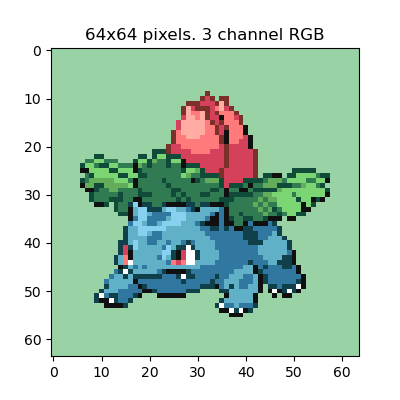

In [354]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(imgs[0])
plt.title("64x64 pixels. 3 channel RGB")
plt.show()

In [355]:
?img_table

Signature: img_table(imgs: numpy.ndarray, path=None)
Docstring:
Создание таблицы из всех изображений с границей в 1 пиксел.
RGB коды в формате 0-255

imgs - массив изображений
path: str - путь для сохранения картинки в формате png
File:      ~/Documents/projects/polytech-study/computer_architecture/course_work/utils.py
Type:      function


/Users/akira/opt/anaconda3/envs/ds-polytech/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


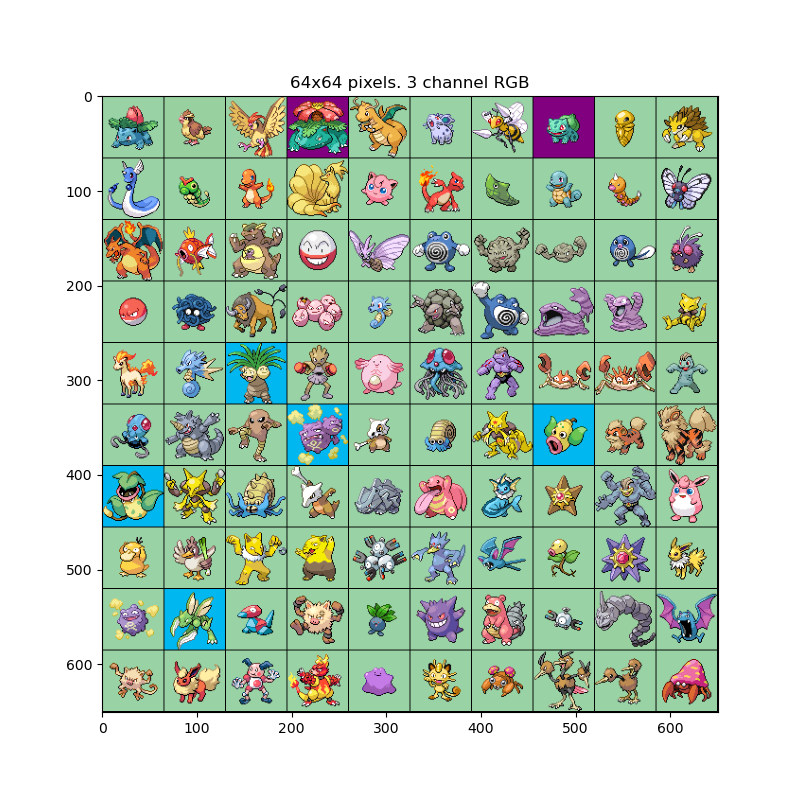

In [356]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_table(imgs[:100]))
plt.title("64x64 pixels. 3 channel RGB")
plt.show()

In [357]:
def img_mean_pxls(imgs: np.ndarray, axis: int) -> np.ndarray:
    """
    Генерирует изображение, где каждый пиксель является усредненным значением
    всех пикселей переданной выборки в каждой из позиций
    
    imgs: выборка изображений
    axis: по какой размерности усреднять
    """
    return np.mean(imgs, axis=axis)

def img_std_pxls(imgs: np.ndarray, axis: int) -> np.ndarray:
    """
    Генерирует изображение, где каждый пиксель является стандартным отклоенением
    всех пикселей переданной выборки в каждой из позиций
    
    imgs: выборка изображений
    axis: по какой размерности усреднять
    """
    return np.std(imgs, axis=axis)


/Users/akira/opt/anaconda3/envs/ds-polytech/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


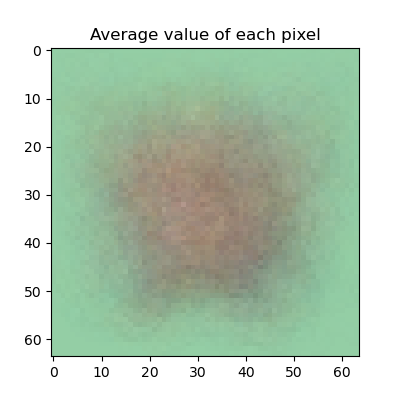

In [358]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(img_mean_pxls(imgs, 0).astype(np.uint8))
plt.title("Average value of each pixel")
plt.show()

/Users/akira/opt/anaconda3/envs/ds-polytech/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


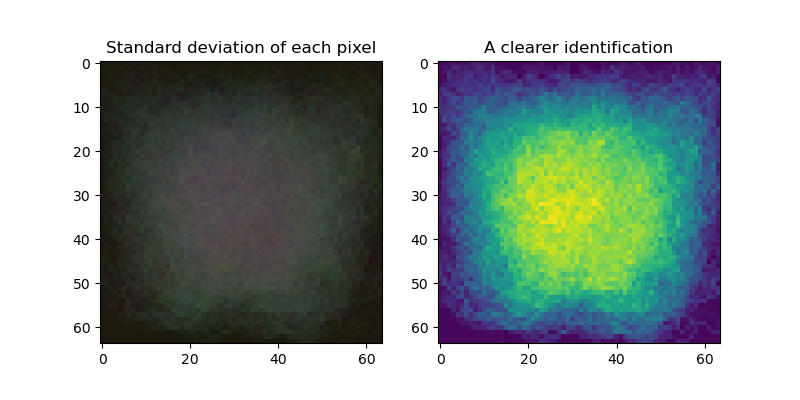

In [359]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(img_std_pxls(imgs, 0).astype(np.uint8))
axs[0].set_title("Standard deviation of each pixel")

axs[1].imshow(np.mean(img_std_pxls(imgs, 0).astype(np.uint8), axis=2))
axs[1].set_title("A clearer identification")
plt.show()

In [360]:
def preprocess(img, imgs) -> np.ndarray:
    """
    Перевод значения цветов пикселя от формата 0-255 к формату 0-1
    
    img: изображение, значения пикселей которых нужно перевести к формату 0-1
    imgs: выборка всех изображений
    """
    norm_img = (img - img_mean_pxls(imgs, 0)) / img_std_pxls(imgs, 0)
    return norm_img

def deprocess(norm_img, imgs)-> np.ndarray:
    """
    Перевод значения цветов пикселя от формата 0-1 к формату 0-255
    
    norm_img: изображение, значения пикселей которых нужно перевести к формату 0-255
    imgs: выборка всех изображений
    """
    img = norm_img * img_std_pxls(imgs, 0) + img_mean_pxls(imgs, 0)
    return img.astype(np.uint8)

## Model

In [361]:
normal_imgs = np.array([
    preprocess(img, imgs)
    for img in imgs
])
X_train, X_test = train_test_split(normal_imgs, test_size=0.1, random_state=13)

In [399]:
def build_deep_ae(img_shape, code_size):
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size*3, activation='relu'))
    encoder.add(Dense(code_size*2, activation='linear'))
    encoder.add(Dense(code_size))
    
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(code_size*2, activation='linear'))
    decoder.add(Dense(code_size*3, activation='relu'))
    decoder.add(Dense(np.prod(img_shape)))
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [400]:
IMG_SHAPE = normal_imgs.shape[1:]
encoder, decoder = build_deep_ae(IMG_SHAPE, 128)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_84 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
sequential_55 (Sequential)   (None, 128)               4850432   
_________________________________________________________________
sequential_56 (Sequential)   (None, 64, 64, 3)         4862592   
Total params: 9,713,024
Trainable params: 9,713,024
Non-trainable params: 0
_________________________________________________________________
None


In [401]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=500,
                validation_data=[X_test, X_test])

Train on 135 samples, validate on 16 samples
Epoch 1/500
135/135 [==============================] - 2s 13ms/step - loss: 1.4898 - val_loss: 0.6002
Epoch 2/500
135/135 [==============================] - 1s 7ms/step - loss: 1.1266 - val_loss: 0.5486
Epoch 3/500
135/135 [==============================] - 1s 7ms/step - loss: 0.9853 - val_loss: 0.5340
Epoch 4/500
135/135 [==============================] - 1s 6ms/step - loss: 0.9056 - val_loss: 0.5239
Epoch 5/500
135/135 [==============================] - 1s 6ms/step - loss: 0.8583 - val_loss: 0.5158
Epoch 6/500
135/135 [==============================] - 1s 7ms/step - loss: 0.8200 - val_loss: 0.5104
Epoch 7/500
135/135 [==============================] - 1s 7ms/step - loss: 0.8199 - val_loss: 0.5063
Epoch 8/500
135/135 [==============================] - 1s 7ms/step - loss: 0.8027 - val_loss: 0.5028
Epoch 9/500
135/135 [==============================] - 1s 7ms/step - loss: 0.7695 - val_loss: 0.5006
Epoch 10/500
135/135 [=======================

In [402]:
def get_reconstructed_images(normal_imgs, encoder, decoder):
    rec_imgs = []
    for img in normal_imgs:
        norm_img = encoder.predict(img[None])[0]
        rec_img = decoder.predict(norm_img[None])[0]
        rec_img = deprocess(rec_img, imgs)
        rec_imgs.append(rec_img)
    return np.array(rec_imgs)

In [403]:
recs = get_reconstructed_images(normal_imgs, encoder, decoder)

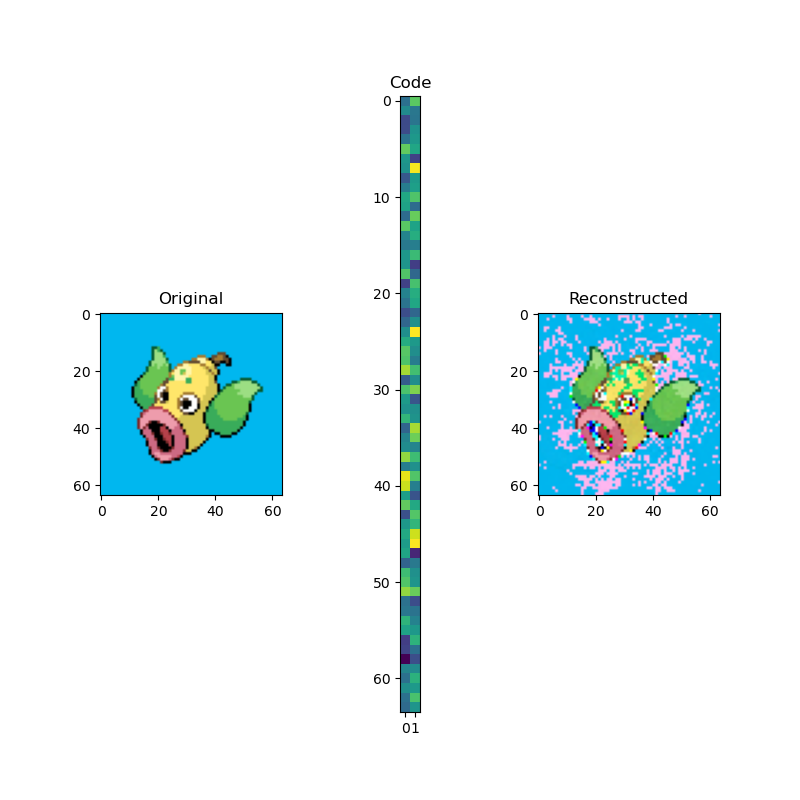

In [404]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    img = deprocess(img, imgs)
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))
    
    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    img = deprocess(reco, imgs)
    plt.imshow(img)
    plt.show()

img = normal_imgs[57]
visualize(img,encoder,decoder)

/Users/akira/opt/anaconda3/envs/ds-polytech/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


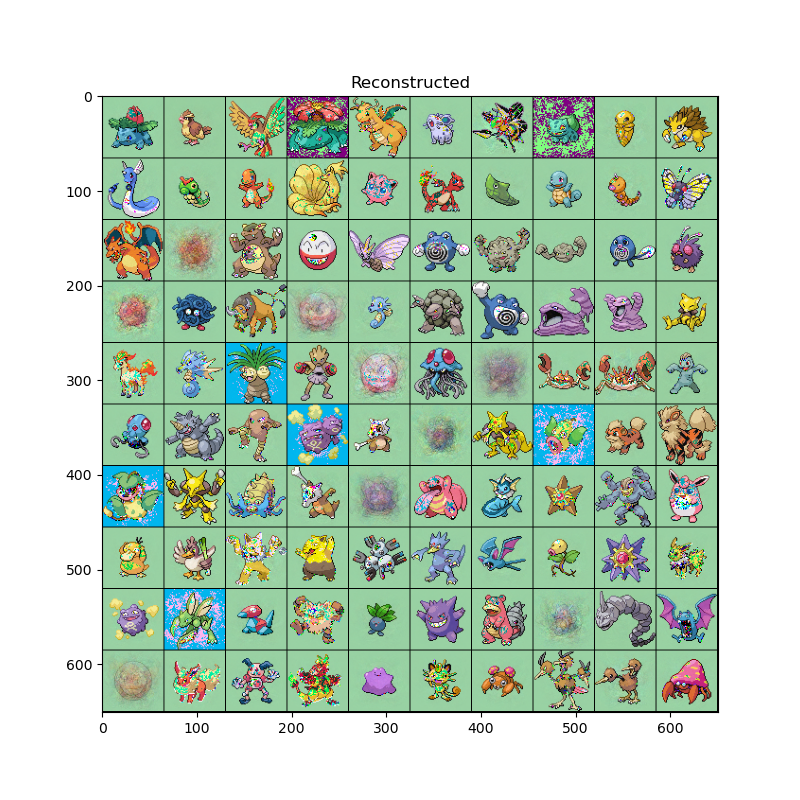

In [405]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_table(recs[:100]))
plt.title("Reconstructed")
plt.show()